## Carichiamo le immagini LDR

Percentuale di informazione mantenuta:
Immagine 1 : 0.9765611111111111
Immagine 2 : 0.9967013888888889
Immagine 3 : 0.9998458333333333


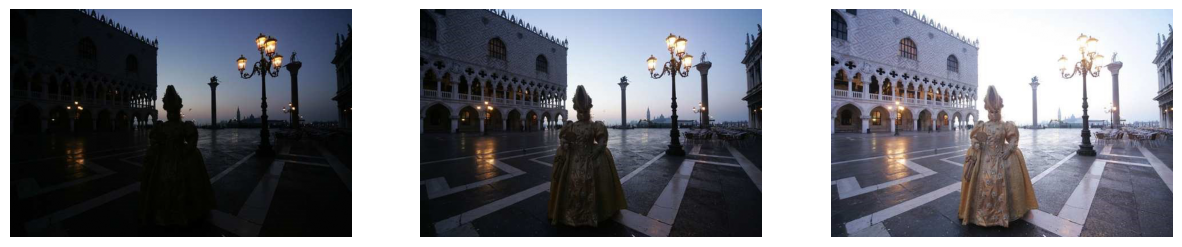

In [205]:
import numpy as np
from PIL import Image
from skimage import img_as_float
import matplotlib.pyplot as plt

DIR_PATH = 'images/2/'

# Carica le immagini e convertile in array NumPy
img1 = img_as_float(np.array(Image.open(f'{DIR_PATH}/image1.jpg').convert('RGB')))
img2 = img_as_float(np.array(Image.open(f'{DIR_PATH}/image2.jpg').convert('RGB')))
img3 = img_as_float(np.array(Image.open(f'{DIR_PATH}/image3.jpg').convert('RGB')))

# Metti le immagini in una lista
images = [img1, img2, img3]

# Visualizza le immagini da fondere
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    ax[i].imshow(images[i])
    ax[i].axis('off')

# Calcola la percentuale di informazione mantenuta
print("Percentuale di informazione mantenuta:")
for i, img in enumerate(images):
    print(f"Immagine {i+1} : {np.count_nonzero(img)/(img.size)}")

## Calcoliamo i pesi delle immagini LDR

Percentuale di informazione mantenuta
Immagine 1: 0.7122916666666667
Immagine 2: 0.9775625
Immagine 3: 0.8718541666666667


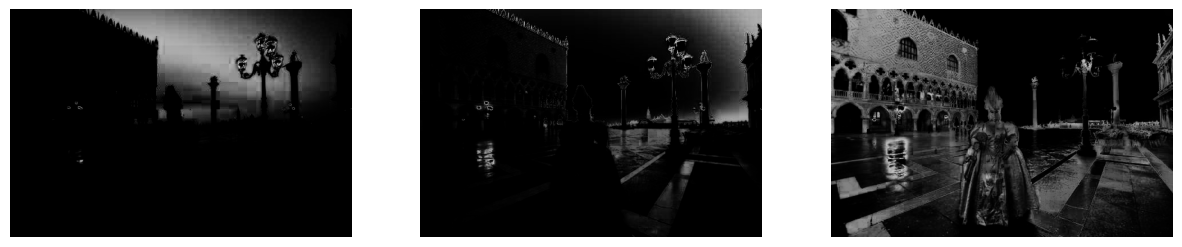

In [206]:
from skimage.color import rgb2gray
# from skimage.filters import laplace, sobel
from scipy.ndimage import gaussian_filter, gaussian_laplace,laplace

def gauss_curve(i,sigma=0.2):
    return np.exp(-(i-0.5)**2/(2*sigma**2))

def calculate_weights(images):
    weights = []
    for img in images:
        # Conversione dell'immagine in scala di grigi
        gray = rgb2gray(img)
        # Calcolo l'indicatore di contrasto applicando il filtro di Laplace sull'immagine in scala di grigi
        # contrast = abs(laplace(gray))
        contrast =abs(gaussian_filter(gray, sigma=1))
        # contrast =abs(gaussian_laplace(gray,sigma=1))


        # Saturazione dell'immagine calcolata come deviazione standard dei valori dei pixel
        saturation = np.std(img, axis=2)
        # Esposizione dell'immagine calcolata come prodotto di gaussiane
        well_exposedness = np.prod(gauss_curve(img), axis=2)

        # Definizione dei pesi
        omega_C=1
        omega_S=1
        omega_E=1
        
        # Calcolo della weight map
        weight_mapped =  (saturation ** omega_S) * (well_exposedness ** omega_E) * (contrast ** omega_C)

        weights.append( weight_mapped)
    return weights

weights = calculate_weights(images)

# Visualizza i pesi calcolati
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    ax[i].imshow(weights[i], cmap='gray')
    ax[i].axis('off')

print("Percentuale di informazione mantenuta")
for i in range(3):
    print(f"Immagine {i+1}: {np.count_nonzero(weights[i])/(weights[i].size)}")

### Esempio dei pesi di un'immagine LDR

1.0
0.9775625
1.0


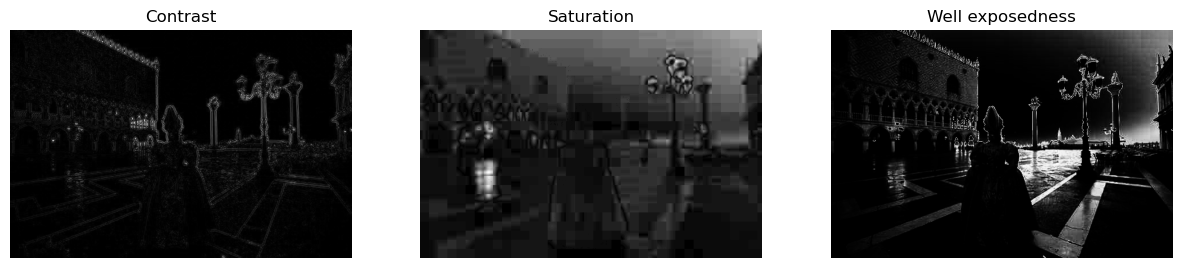

In [219]:
from skimage.filters import sobel
from scipy.ndimage import convolve


sample_img = img2

def my_std(img):
    return np.std(img, axis=2)

gray = rgb2gray(sample_img)
# img_contrast = abs(gaussian_filter(gray,sigma=1))
img_contrast = abs(convolve(gray, np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])))
# img_contrast = abs(sobel(gray))
img_contrast = abs(gaussian_laplace(gray,mode='reflect',sigma=1))
# Saturazione dell'immagine calcolata come deviazione standard dei valori dei pixel
img_saturation = np.std(sample_img, axis=2)
# Esposizione dell'immagine calcolata come prodotto di) gaussiane
img_well_exposedness = np.prod(gauss_curve(sample_img), axis=2)

# Visualizza i tre indicatori di qualità dell'immagine
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(img_contrast, cmap='gray')
ax[0].set_title('Contrast')
ax[0].axis('off')
ax[1].imshow(img_saturation, cmap='gray')
ax[1].set_title('Saturation')
ax[1].axis('off')
ax[2].imshow(img_well_exposedness, cmap='gray')
ax[2].set_title('Well exposedness')
ax[2].axis('off')

print(np.count_nonzero(img_contrast)/(img_contrast.size))
print(np.count_nonzero(img_saturation)/(img_saturation.size))
print(np.count_nonzero(img_well_exposedness)/(img_well_exposedness.size))


## Normalizzazione dei pesi delle immagini LDR

/tmp/ipykernel_1685/2004942130.py:20: RuntimeWarning: invalid value encountered in divide
  normalized_weights = weights / sum


Percentuale di informazione mantenuta
Immagine 1: 0.7127375
Immagine 2: 0.9780083333333334
Immagine 3: 0.8723


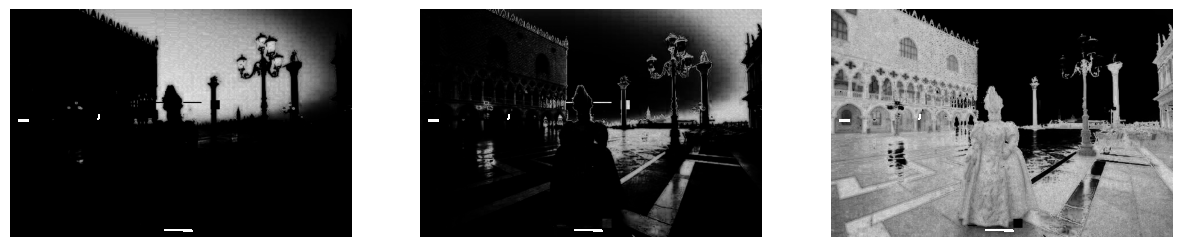

In [208]:
def normalize_weights(weights):
    normalized_weights = []
    total_weight = np.sum(weights, axis=0)
    
    # Check if total_weight contains zeros to avoid division by zero
    if np.any(total_weight == 0):
        raise ValueError("Sum of weights contains zero, cannot normalize.")

    # Normalizzazione dei pesi
    for img_weight in weights:
        # Calcolo del peso normalizzato
        normalized_weight = img_weight / total_weight
        normalized_weights.append(normalized_weight)

    return normalized_weights

# TODO: Risolvere il problema della divisione per zero
for w in weights:
    sum += w
normalized_weights = weights / sum
# normalized_weights = normalize_weights(weights)

# Visualizza i pesi normalizzati
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    ax[i].imshow(normalized_weights[i], cmap='gray')
    ax[i].axis('off')

print("Percentuale di informazione mantenuta")
for i in range(3):
    print(f"Immagine {i+1}: {np.count_nonzero(normalized_weights[i])/(normalized_weights[i].size)}")

### Visualizzimo i pesi delle immagini LDR del paper

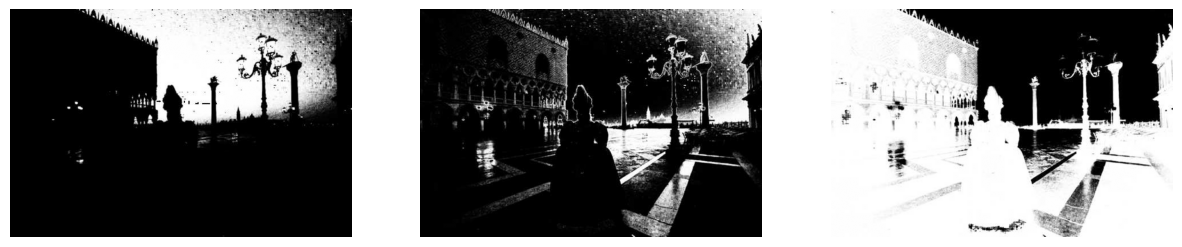

In [209]:
# Caricare le immagini pesate del paper
mapped_images_paper = [img_as_float(np.array(Image.open(f'{DIR_PATH}/image{i}_mapped.jpg').convert('RGB'))) for i in range(1, 4)]

# Visualizza le immagini pesate del paper
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    ax[i].imshow(mapped_images_paper[i])
    ax[i].axis('off')

### Risultato parziale

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 599.5, 399.5, -0.5)

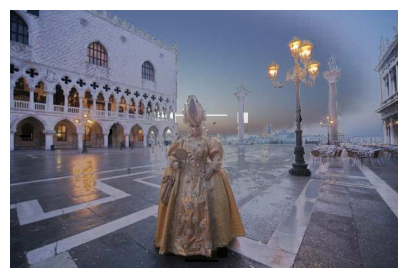

In [215]:
# Calcolo risultato parziale dell'immagine

# Inizializza l'immagine risultante
result = np.zeros_like(images[0], dtype=np.float64)

for i,w in enumerate(normalized_weights):
    result+= w[:, :, np.newaxis] * images[i]

# Visualizza il risultato parziale
plt.figure(figsize=(5, 5))
plt.imshow(result)
plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


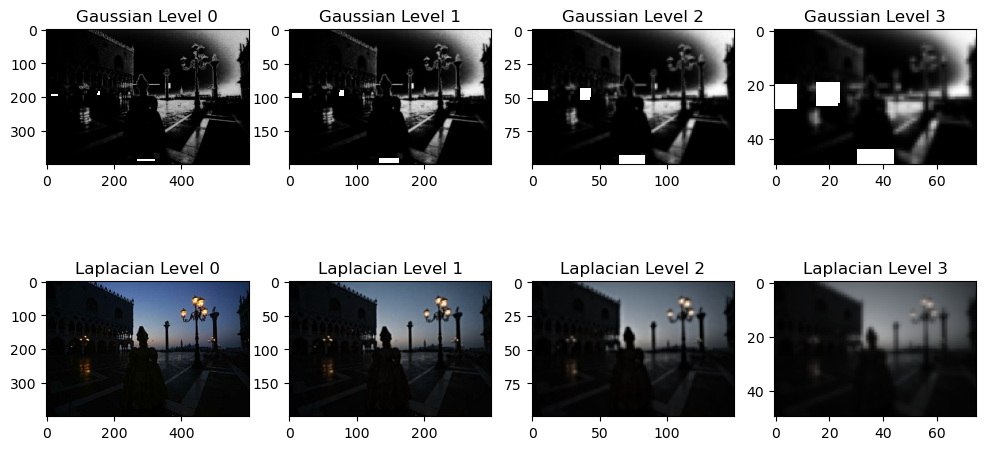

In [211]:
import numpy as np
from scipy.ndimage import gaussian_filter, laplace
from skimage.transform import pyramid_gaussian

def gaussian_pyramid(image, levels):
    pyramid = [image]
    for _ in range(levels):
        image = gaussian_filter(image, sigma=1)
        image = image[::2, ::2]  # Downsample
        pyramid.append(image)
    return pyramid

def laplacian_pyramid(image, levels):
    gaussian_pyr = gaussian_pyramid(image, levels)
    laplacian_pyr = []
    for i in range(levels):
        next_level = gaussian_pyr[i + 1]
        upsampled = np.repeat(np.repeat(next_level, 2, axis=0), 2, axis=1)
        laplacian = gaussian_pyr[i] - gaussian_laplace(upsampled, sigma=1)
        laplacian_pyr.append(laplacian)
    laplacian_pyr.append(gaussian_pyr[-1])
    return laplacian_pyr

# Carica un'immagine di esempio
image = img1
weight = normalized_weights[1]

# Genera le piramidi
gaussian_pyr = gaussian_pyramid(weight, 3)
laplacian_pyr = laplacian_pyramid(image, 3)

# Visualizza i risultati
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i in range(4):
    axes[0, i].imshow(gaussian_pyr[i], cmap='gray')
    axes[0, i].set_title(f'Gaussian Level {i}')
    axes[1, i].imshow(laplacian_pyr[i], cmap='gray')
    axes[1, i].set_title(f'Laplacian Level {i}')
plt.show()

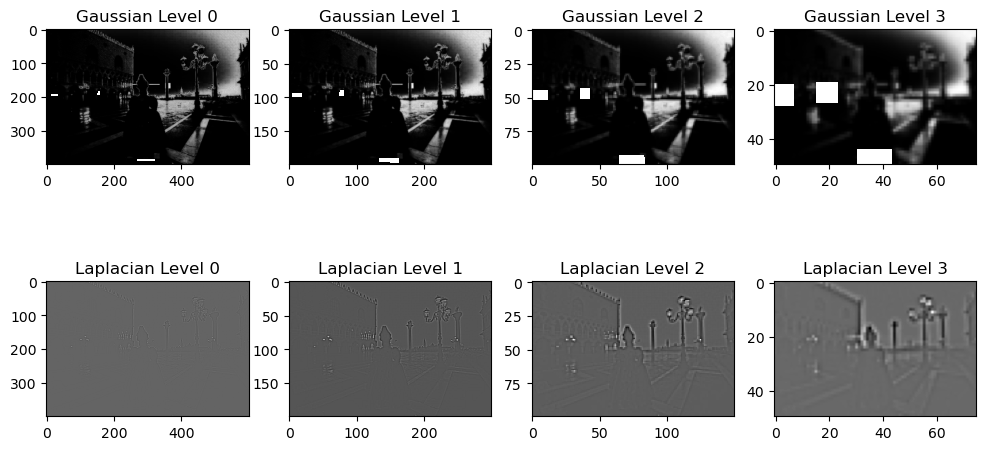

In [212]:
from skimage.transform import pyramid_gaussian, pyramid_laplacian

# Carica un'immagine di esempio
image = img1
weight = normalized_weights[1]

# Genera le piramidi
gaussian_pyr = list(pyramid_gaussian(weight, max_layer=3))
laplacian_pyr = list(pyramid_laplacian(rgb2gray(image), max_layer=3))

# Visualizza i risultati
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i in range(4):
    axes[0, i].imshow(gaussian_pyr[i], cmap='gray')
    axes[0, i].set_title(f'Gaussian Level {i}')
    axes[1, i].imshow(laplacian_pyr[i], cmap='gray')
    axes[1, i].set_title(f'Laplacian Level {i}')
plt.show()



In [213]:
gaussian_weights = [list(pyramid_gaussian(weight, max_layer=3)) for weight in normalized_weights]
laplacian_images = [list(pyramid_laplacian(rgb2gray(image), max_layer=3)) for image in images]

# Inizializza l'immagine risultante
result_pyr = np.zeros_like(images[0], dtype=np.float64)
result_pyr = np.zeros_like(laplacian_images[0][0], dtype=np.float64)

for i,w in enumerate(normalized_weights):
    result+= w[:, :, np.newaxis] * images[i]

## Uniamo le immagini insieme ai pesi per creare l'immagine HDR

/tmp/ipykernel_1685/3084331124.py:3: RuntimeWarning: invalid value encountered in divide
  normalized_weights = [w / total_weight for w in weights]
/tmp/ipykernel_1685/3084331124.py:16: RuntimeWarning: invalid value encountered in cast
  fused_image = np.clip(fused_image * 255, 0, 255).astype('uint8')


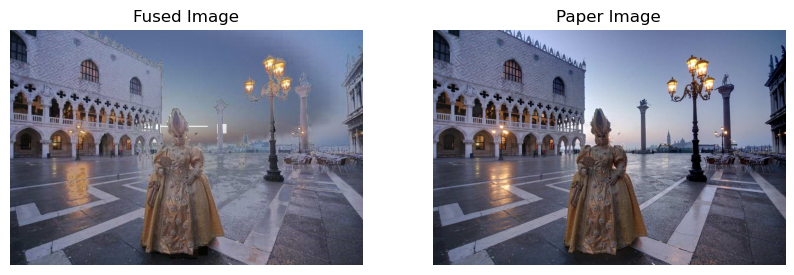

In [214]:
def normalize_weights(weights):
    total_weight = np.sum(weights, axis=0)
    normalized_weights = [w / total_weight for w in weights]
    return normalized_weights

normalized_weights = normalize_weights(weights)

# Inizializza l'immagine risultante
fused_image = np.zeros_like(images[0])

# Calcola la media ponderata
for img, weight in zip(images, normalized_weights):
    fused_image += img * weight[..., np.newaxis]

# Converti l'immagine risultante in formato 8-bit
fused_image = np.clip(fused_image * 255, 0, 255).astype('uint8')

# Salva l'immagine risultante
result_image = Image.fromarray(fused_image)
result_image.save(f'{DIR_PATH}/fused_image.jpg')

# Visualizza l'immagine risultante in confronto all'immagine risultante del paper
paper_image = Image.open(f'{DIR_PATH}/result.jpg')
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(result_image)
ax[0].axis('off')
ax[0].set_title('Fused Image')
ax[1].imshow(paper_image)
ax[1].axis('off')
ax[1].set_title('Paper Image')
plt.show()

